In [ ]:
# Copyright 2022 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Getting started: Serving Models with NVIDIA Triton Inference Server with a custom container 

<hr/>

<table align="left">
  <tr>
      <td>
        <a align="center" href="https://colab.research.google.com/github/GoogleCloudPlatform/vertex-ai-samples/tree/master/notebooks/official/custom/snvidia-triton-custom-container-prediction.ipynb">
          <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
        </a>
      </td>
      <td>
        <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/tree/master/notebooks/official/custom/snvidia-triton-custom-container-prediction.ipynb">
          <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
          View on GitHub
        </a>
      </td>
      <td>
        <a href="https://console.cloud.google.com/ai/platform/notebooks/deploy-notebook?download_url=https://github.com/GoogleCloudPlatform/vertex-ai-samples/tree/master/notebooks/official/custom/snvidia-triton-custom-container-prediction.ipynb">
            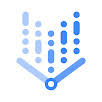
          Run on Vertex AI Workbench
        </a>
      </td>
    </tr>
</table>
<br/>
<br/>
<br/>

<hr/>

## Overview

This tutorial shows how to use a custom container running [NVIDIA Triton Inference Server (Triton)](https://developer.nvidia.com/nvidia-triton-inference-server) to deploy a machine learning (ML) model on [Vertex AI Prediction](https://cloud.google.com/vertex-ai/docs/predictions/getting-predictions) that serves online predictions.

## Dataset

The tutorial uses Faster R-CNN with ResNet-101 v1 object detection model provided on [TensorFlow Hub](https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_640x640/1) that has been trained on the [COCO 2017 dataset](https://cocodataset.org/#download) with training images scaled to 640x640.

## Objective

In this tutorial, you deploy a container running Triton to serve predictions from an object detection model on Vertex AI Predictions and then use the Vertex AI Endpoints to detect objects in an image.

The steps performed in this tutorial include:

- Download the model artifacts from TensorFlow Hub
- Create Triton configuration file
- Build custom container running Triton
- Upload the model as a Vertex `Model` resource
- Deploy the `Model` resource to a serving `Endpoint` resource.
- Make a prediction request
- Undeploy the `Model` resource and delete the `Endpoint`

### Costs

This tutorial uses billable components of Google Cloud:

* Vertex AI
* Cloud Storage

Learn about [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing) and [Cloud Storage pricing](https://cloud.google.com/storage/pricing), and use the [Pricing Calculator](https://cloud.google.com/products/calculator/) to generate a cost estimate based on your projected usage.

## NVIDIA Triton Inference Server (Triton) Overview

[NVIDIA Triton Inference Server (Triton)](https://github.com/triton-inference-server/server) provides an inference solution optimized for both CPUs and GPUs. Triton can run multiple models from the same or different frameworks concurrently on a single GPU or CPU. In a multi-GPU server, it automatically creates an instance of each model on each GPU to increase utilization without extra coding. It supports real-time inferencing, batch inferencing to maximize GPU/CPU utilization, and streaming inference with built-in support for audio streaming input. It also supports model ensembles for use cases that require multiple models to perform end-to-end inference.

The following figure shows the Triton's high-level architecture.

![Triton high level architecture](https://raw.githubusercontent.com/triton-inference-server/server/main/docs/images/arch.jpg)

- The model repository is a file-system based repository of the models that Triton will make available for inference.
- Inference requests arrive at the server via either HTTP/REST or gRPC and are then routed to the appropriate per-model scheduler.
- Triton implements multiple scheduling and batching algorithms that can be configured on a model-by-model basis.
- The backend performs inference using the inputs provided in the batched requests to produce the requested outputs.

Triton provides readiness and liveness health endpoints, as well as utilization, throughput, and latency metrics, which enable the integration of Triton into deployment environments, such as Vertex AI Prediction.

Refer to [Triton architecture](https://github.com/triton-inference-server/server/blob/main/docs/architecture.md) for more detailed information.

## Triton on Vertex AI Prediction

Triton inference server runs inside a container published by NVIDIA GPU Cloud (NGC) - [NVIDIA Triton Inference Server Image](https://catalog.ngc.nvidia.com/orgs/nvidia/containers/tritonserver). NVIDIA and GCP Vertex team collaborate and adds packages and configurations to align Triton with Vertex AI [requirements for custom serving container images](https://cloud.google.com/vertex-ai/docs/predictions/custom-container-requirements).

The model to be served by Triton should be registered with Vertex AI as a `Model` resource. The `Model`'s metadata reference a location of the ensemble artifacts in Google Cloud Storage (GCS) and the custom serving container and its configurations.

Triton loads the models and exposes inference, health, and model management REST endpoints using [standard inference protocols](https://github.com/kserve/kserve/tree/master/docs/predict-api/v2). While deploying to Vertex AI, Triton recognizes Vertex AI environment and adopts Vertex AI Prediction protocol for [health checks](https://cloud.google.com/vertex-ai/docs/predictions/custom-container-requirements#health) and predictions.

To invoke the model through the Vertex AI Prediction endpoint, format prediction request using a [standard Inference Request JSON Object](https://github.com/kserve/kserve/blob/master/docs/predict-api/v2/required_api.md#inference) or a [Inference Request JSON Object with a binary extension](https://github.com/triton-inference-server/server/blob/main/docs/protocol/extension_binary_data.md) and submit a request to Vertex AI Prediction [REST rawPredict endpoint](https://cloud.google.com/vertex-ai/docs/reference/rest/v1beta1/projects.locations.endpoints/rawPredict). You need to use the `rawPredict` rather than `predict` endpoint because inference request formats used by Triton are not compatible with the Vertex AI Prediction [standard input format](https://cloud.google.com/vertex-ai/docs/predictions/online-predictions-custom-models#formatting-prediction-input).

## Set up your local development environment

If you are using Google Colab or [Vertex AI Workbench](https://cloud.google.com/vertex-ai/docs/workbench/introduction), your environment already meets all the requirements to run this notebook. You can skip this step. Please make sure you are running the notebook in TensorFlow kernel in the Vertex AI Workbench notebook environment.

Otherwise, make sure your environment meets this notebook's requirements. You need the following:

- The Cloud Storage SDK
- Git
- Python 3
- virtualenv
- Jupyter notebook running in a virtual environment with Python 3

The Cloud Storage guide to [Setting up a Python development environment](https://cloud.google.com/python/setup) and the [Jupyter installation guide](https://jupyter.org/install) provide detailed instructions for meeting these requirements. The following steps provide a condensed set of instructions:

1. [Install and initialize the SDK](https://cloud.google.com/sdk/docs/).
2. [Install Python 3](https://cloud.google.com/python/setup#installing_python).
3. [Install virtualenv](https://cloud.google.com/python/setup#installing_and_using_virtualenv) and create a virtual environment that uses Python 3.
4. Activate that environment and run `pip3 install Jupyter` in a terminal shell to install Jupyter.
5. Run `jupyter notebook` on the command line in a terminal shell to launch Jupyter.
6. Open this notebook in the Jupyter Notebook Dashboard.


## Installation

Install the latest version of [Vertex AI SDK for Python](https://cloud.google.com/vertex-ai/docs/start/client-libraries#python).

In [ ]:
import os

# Google Cloud Notebook
if os.path.exists("/opt/deeplearning/metadata/env_version"):
    USER_FLAG = "--user"
else:
    USER_FLAG = ""

! pip3 install --upgrade google-cloud-aiplatform $USER_FLAG

In [ ]:
if os.getenv("IS_TESTING"):
    ! pip3 install --upgrade tensorflow $USER_FLAG

### Restart the kernel

Once you've installed the additional packages, you need to restart the notebook kernel so it can find the packages.

In [ ]:
import os

if not os.getenv("IS_TESTING"):
    # Automatically restart kernel after installs
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

## Before you begin

### GPU runtime

This tutorial does not require a GPU runtime.

### Set up your Google Cloud project

**The following steps are required, regardless of your notebook environment.**

1. [Select or create a Google Cloud project](https://console.cloud.google.com/cloud-resource-manager). When you first create an account, you get a $300 free credit towards your compute/storage costs.

2. [Make sure that billing is enabled for your project.](https://cloud.google.com/billing/docs/how-to/modify-project)

3. [Enable the following APIs: Vertex AI APIs, Compute Engine APIs, and Cloud Storage.](https://console.cloud.google.com/flows/enableapi?apiid=ml.googleapis.com,compute_component,storage-component.googleapis.com)

4. [The Google Cloud SDK](https://cloud.google.com/sdk) is already installed in Google Cloud Notebook.

5. Enter your project ID in the cell below. Then run the  cell to make sure the
Cloud SDK uses the right project for all the commands in this notebook.

**Note**: Jupyter runs lines prefixed with `!` as shell commands, and it interpolates Python variables prefixed with `$`.

In [ ]:
PROJECT_ID = "[your-project-id]"  # @param {type:"string"}

In [ ]:
import os

# Get your Google Cloud project ID using google.auth
if not os.getenv("IS_TESTING"):
    import google.auth

    _, PROJECT_ID = google.auth.default()
    print("Project ID: ", PROJECT_ID)

# validate PROJECT_ID
if PROJECT_ID == "" or PROJECT_ID is None or PROJECT_ID == "[your-project-id]":
    print(
        f"Please set your project id before proceeding to next step. Currently it's set as {PROJECT_ID}"
    )

In [ ]:
! gcloud config set project $PROJECT_ID

#### Region

You can also change the `REGION` variable, which is used for operations
throughout the rest of this notebook.  Below are regions supported for Vertex AI. We recommend that you choose the region closest to you.

- Americas: `us-central1`
- Europe: `europe-west4`
- Asia Pacific: `asia-east1`

You may not use a multi-regional bucket for training with Vertex AI. Not all regions provide support for all Vertex AI services.

Learn more about [Vertex AI regions](https://cloud.google.com/vertex-ai/docs/general/locations)

In [ ]:
REGION = "us-central1"  # @param {type: "string"}

#### Timestamp

If you are in a live tutorial session, you might be using a shared test account or project. To avoid name collisions between users on resources created, you create a timestamp for each instance session, and append the timestamp onto the name of resources you create in this tutorial.

In [ ]:
from datetime import datetime

TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

#### Authenticate your Google Cloud account

---

**If you are using Google Cloud Notebook**, your environment is already authenticated. Skip this step.

**If you are using Colab**, run the cell below and follow the instructions when prompted to authenticate your account via oAuth.

---

**Otherwise**, follow these steps:

- In the Cloud Console, go to the [Create service account key](https://console.cloud.google.com/apis/credentials/serviceaccountkey) page.
- **Click Create service account**.
- In the **Service account name** field, enter a name, and click **Create**.
- In the **Grant this service account access to project** section, click the Role drop-down list. Type "Vertex" into the filter box, and select **Vertex Administrator**. Type "Storage Object Admin" into the filter box, and select **Storage Object Admin**.
- Click Create. A JSON file that contains your key downloads to your local environment.
- Enter the path to your service account key as the GOOGLE_APPLICATION_CREDENTIALS variable in the cell below and run the cell.

In [ ]:
# If you are running this notebook in Colab, run this cell and follow the
# instructions to authenticate your GCP account. This provides access to your
# Cloud Storage bucket and lets you submit training jobs and prediction
# requests.

import os
import sys

# If on Google Cloud Notebook, then don't execute this code
if not os.path.exists("/opt/deeplearning/metadata/env_version"):
    if "google.colab" in sys.modules:
        from google.colab import auth as google_auth

        google_auth.authenticate_user()

    # If you are running this notebook locally, replace the string below with the
    # path to your service account key and run this cell to authenticate your GCP
    # account.
    elif not os.getenv("IS_TESTING"):
        %env GOOGLE_APPLICATION_CREDENTIALS ''

### Create a Cloud Storage bucket

**The following steps are required, regardless of your notebook environment.**

When you initialize the Vertex SDK for Python, you specify a Cloud Storage staging bucket. The staging bucket is where all the data associated with your dataset and model resources are retained across sessions.

Set the name of your Cloud Storage bucket below. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.

In [ ]:
BUCKET_NAME = "gs://[your-bucket-name]"  # @param {type:"string"}

In [ ]:
if BUCKET_NAME == "" or BUCKET_NAME is None or BUCKET_NAME == "gs://[your-bucket-name]":
    BUCKET_NAME = "gs://" + PROJECT_ID + "aip-" + TIMESTAMP

---

**Only if your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

---

In [ ]:
! gsutil mb -l $REGION $BUCKET_NAME

Finally, validate access to your Cloud Storage bucket by examining its contents:

In [ ]:
! gsutil ls -al $BUCKET_NAME

### Set up variables

Next, set up some variables used throughout the tutorial.
### Import libraries and define constants

In [ ]:
import os
import json 
from pathlib import Path
import requests
import numpy as np
from PIL import Image

from google.api import httpbody_pb2
from google.cloud import aiplatform as aip
from google.cloud import aiplatform_v1 as gapic
from google.protobuf.json_format import MessageToDict

`MODEL_ARTIFACTS_REPOSITORY` is a root GCS location where the Triton model artifacts will be stored.

In [ ]:
MODEL_ARTIFACTS_REPOSITORY = f'{BUCKET_NAME}/triton-on-vertex/models'

The following set of constants will be used to create names and display names of Vertex Prediction resources like models, endpoints, and model deployments.

In [ ]:
MODEL_NAME = 'faster-rcnn'
MODEL_VERSION = 'v01'
MODEL_DISPLAY_NAME = f'triton-{MODEL_NAME}-{MODEL_VERSION}'
ENDPOINT_DISPLAY_NAME = f'endpoint-{MODEL_NAME}-{MODEL_VERSION}'

# Triton image uri from 
# https://catalog.ngc.nvidia.com/orgs/nvidia/containers/tritonserver
NGC_TRITON_IMAGE_URI = "nvcr.io/nvidia/tritonserver:22.01-py3"

IMAGE_NAME = 'vertex-triton-inference:22.01'
IMAGE_URI = f"gcr.io/{PROJECT_ID}/{IMAGE_NAME}"

### Initialize Vertex SDK for Python

Initialize the Vertex SDK for Python for your project and corresponding bucket.

In [ ]:
aip.init(project=PROJECT_ID, staging_bucket=BUCKET_NAME)

## Download model artifacts

For this tutorial, download the object detection model provided on [TensorFlow Hub](https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_640x640/1) that has been trained on the [COCO 2017 dataset](https://cocodataset.org/#download). Triton expects model repository to be organized in the following structure for serving [TensorFlow `SavedModel`](https://www.tensorflow.org/guide/saved_model) formats:

> ```
> └── model-repository-path
>        └── model_name
>               ├── config.pbtxt
>               └── 1
>                   └── model.savedmodel
>                         └── <saved-model-files>
> ```


The `config.pbtxt` file describes the [model configuration](https://github.com/triton-inference-server/server/blob/main/docs/model_configuration.md) for the model.

In [ ]:
! mkdir -p models/object_detector/1/model.savedmodel/
! curl -L "https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_640x640/1?tf-hub-format=compressed" | \
    tar -zxvC ./models/object_detector/1/model.savedmodel/
! ls -ltr ./models/object_detector/1/model.savedmodel/

After downloading the model locally, model repository will be organized as following:

> ```
> ./models
> └── object_detector
>     └── 1
>         └── model.savedmodel
>             ├── saved_model.pb
>             └── variables
>                 ├── variables.data-00000-of-00001
>                 └── variables.index
> ```

In [ ]:
!tree ./models

### Create model configuration file

The [model configuration](https://github.com/triton-inference-server/server/blob/main/docs/model_configuration.md) file `config.pbtxt` provides information about the model such as inputs and outputs. Refer to the [Triton docs](https://github.com/triton-inference-server/common/blob/main/protobuf/model_config.proto) for the configuration format. For TensorFlow models, you could use the [`saved_model_cli` command](https://www.tensorflow.org/guide/saved_model#details_of_the_savedmodel_command_line_interface) and map to the Triton's configuration format. Note that Triton datatypes are different from the frameworks and should be mapped accordingly based on the table [here](https://github.com/triton-inference-server/server/blob/main/docs/model_configuration.md#datatypes).

In [ ]:
!saved_model_cli show --dir ./models/object_detector/1/model.savedmodel/ --all

In [ ]:
%%writefile ./models/object_detector/config.pbtxt

name: "object_detector"
platform: "tensorflow_savedmodel"
backend: "tensorflow"
max_batch_size: 0
input [
  {
    name: "input_tensor"
    data_type: TYPE_UINT8
    dims: [ 1, -1, -1, 3 ]
  }
]
output [
  {
    name: "detection_anchor_indices"
    data_type: TYPE_FP32
    dims: [ 1, 300 ]
  },
  {
    name: "detection_boxes"
    data_type: TYPE_FP32
    dims: [ 1, 300, 4 ]
  },
  {
    name: "detection_classes"
    data_type: TYPE_FP32
    dims: [ 1, 300 ]
  },
  {
    name: "detection_multiclass_scores"
    data_type: TYPE_FP32,
    dims: [ 1, 300, 91]
  },
  {
    name: "detection_scores"
    data_type: TYPE_FP32
    dims: [ 1, 300 ]
  },
  {
    name: "num_detections"
    data_type: TYPE_FP32
    dims: [ 1 ]
  },
  {
    name: "raw_detection_boxes"
    data_type: TYPE_FP32
    dims: [ 1, 300, 4 ]
  },
  {
    name: "raw_detection_scores"
    data_type: TYPE_FP32
    dims: [ 1, 300, 91 ]
  }
]

### Push model artifacts to GCS Bucket

The downloaded model artifacts including model configuration file are pushed to GCS bucket defined by `MODEL_ARTIFACTS_REPOSITORY` which will be used when creating the Vertex AI Model resource.

In [ ]:
! gsutil cp -r ./models/object_detector $MODEL_ARTIFACTS_REPOSITORY/

Validate model artifacts are copied in the GCS model artifacts uri location.

In [ ]:
!gsutil ls -r $MODEL_ARTIFACTS_REPOSITORY/object_detector/

## Building and pushing the container image

To use a custom container for serving predictions, you must specify a Docker container image that meets the [custom container requirements](https://cloud.google.com/vertex-ai/docs/predictions/custom-container-requirements). This section describes how to create the container image running Triton and push it to Google Artifact Registry or Google Container Registry (GCR). This tutorial shows how to push the custom container to GCR.

In [ ]:
! docker pull $NGC_TRITON_IMAGE_URI
! docker tag $NGC_TRITON_IMAGE_URI $IMAGE_URI

### Run the container locally *[optional]*

Before pushing the custom container image to GCR to use it with Vertex AI Predictions, run the container in local environment to verify that the server responds to prediction instances.

1. To run the container image as a container locally, run the following command:

In [ ]:
! docker stop local_object_detector
! docker run -t -d -p 8000:8000 --rm \
    --name=local_object_detector \
    -e AIP_MODE=True \
    $IMAGE_URI \
    --model-repository $MODEL_ARTIFACTS_REPOSITORY
! sleep 10

In [ ]:
# check if the triton container is running locally
!docker container ls -f"name=local_object_detector" --no-trunc

2. To send the container's server a health check, run the following command. It should return the status code as `200`

In [ ]:
! curl -s -o /dev/null -w "%{http_code}" http://localhost:8000/v2/health/ready

3. To send the container's server a prediction request, run the following command to download a sample image file, format the payload and get prediction responses

In [ ]:
def generate_payload(image_url):
    # download image to memory and resize
    image_inputs = Image.open(requests.get(image_url, stream=True).raw).resize((200, 200))
    # convert image to numpy array
    image_tensor = np.asarray(image_inputs)
    # derive image shape
    image_shape = [1] + list(image_tensor.shape)

    # create/set directory to save payload
    base = Path('./test')
    base.mkdir(exist_ok=True)

    # create payload request
    payload = {
        "id": "0",
        "inputs": [
            {
                "name": "input_tensor",
                "shape": image_shape,
                "datatype": "UINT8",
                "parameters": {},
                "data": image_tensor.tolist()
            }
        ]
    }

    # save payload as json file
    payload_file = os.path.join(base, 'payload.json')
    with open(payload_file, 'w') as f:
        json.dump(payload, f)
    print(f"Payload generated at {payload_file}")
    
    return payload_file

In [ ]:
# set image url
image_url = 'https://github.com/tensorflow/models/raw/master/research/object_detection/test_images/image2.jpg'
# generate payload
payload_file = generate_payload(image_url)

In [ ]:
# request prediction response
! curl -X POST -H "Content-Type: application/octet-stream" \
    -H "Accept: */*" \
    --data-binary @$payload_file \
    localhost:8000/v2/models/object_detector/infer

4. To stop the container, run the following command:

In [ ]:
!docker stop local_object_detector

### Push the container image to Container Registry

After testing the container image locally, push the image to GCR. The GCR image URI will be used when creating the Vertex AI model resource.

In [ ]:
! docker push $IMAGE_URI

## Create Vertex AI Model resource

A  Vertex AI Model resource must be created to deploy the model to a Vertex AI Prediction Endpoint. Create a Vertex AI Model resource with the deployment image pointing to the model artifacts. Refer to [Vertex AI Prediction guide](https://cloud.google.com/vertex-ai/docs/predictions/use-custom-container) for creating Vertex AI Model resource with custom container.

In [ ]:
model = aip.Model.upload(
    display_name=MODEL_DISPLAY_NAME,
    serving_container_image_uri=IMAGE_URI,
    artifact_uri=MODEL_ARTIFACTS_REPOSITORY,
    sync=True
)

model.resource_name

## Deploy the model to Vertex AI Predictions

Deploying a Vertex AI Prediction Model is a two step process.

1. Create an `Endpoint` exposing an external interface to users consuming the model. 
2. After the `Endpoint` is ready, deploy multiple versions of a model to the `Endpoint`. The deployed model runs the custom container image running Triton to serve predictions.

Refer to Vertex AI Predictions guide to [Deploy a model using the Vertex AI API](https://cloud.google.com/vertex-ai/docs/predictions/deploy-model-api) for more information about the APIs used in the following cells.

### Create an endpoint

Before deploying the model you need to create a Vertex AI Prediction endpoint.

In [ ]:
endpoint = aip.Endpoint.create(
    display_name=ENDPOINT_DISPLAY_NAME
)

### Deploy model to an endpoint

After the endpoint is ready, deploy model to the endpoint.The deployed model runs the Triton Server on a GPU node equipped with the NVIDIA Tesla T4 GPUs. Refer to [Deploy a model using the Vertex AI API](https://cloud.google.com/vertex-ai/docs/predictions/deploy-model-api) guide for more information.

**NOTE:** This step can take up to ~20 min.

In [ ]:
traffic_percentage = 100
machine_type = "n1-standard-4"
accelerator_type="NVIDIA_TESLA_T4"
accelerator_count = 1
min_replica_count = 1
max_replica_count = 2

model.deploy(
    endpoint=endpoint,
    deployed_model_display_name=MODEL_DISPLAY_NAME,
    machine_type=machine_type,
    min_replica_count=min_replica_count,
    max_replica_count=max_replica_count,
    traffic_percentage=traffic_percentage,
    accelerator_type=accelerator_type,
    accelerator_count=accelerator_count,
    sync=True,
)

endpoint.name

## Invoking the model and getting predictions

To invoke the model through Vertex AI Prediction endpoint, format prediction request using a [standard Inference Request JSON Object](https://github.com/kserve/kserve/blob/master/docs/predict-api/v2/required_api.md#inference) or a [Inference Request JSON Object with a binary extension](https://github.com/triton-inference-server/server/blob/main/docs/protocol/extension_binary_data.md) and submit the request to Vertex AI Prediction [REST rawPredict endpoint](https://cloud.google.com/vertex-ai/docs/reference/rest/v1beta1/projects.locations.endpoints/rawPredict). 

Instead of `predict` API, you must use the `rawPredict` API  because prediction request formats used by Triton are not compatible with the Vertex AI Prediction [standard input format](https://cloud.google.com/vertex-ai/docs/predictions/online-predictions-custom-models#formatting-prediction-input).

The following cell shows a sample request body formatted as a [standard Inference Request JSON Object](https://github.com/kserve/kserve/blob/master/docs/predict-api/v2/required_api.md#inference).

**Generate payload file**

In [ ]:
# set image url
image_url = 'https://github.com/tensorflow/models/raw/master/research/object_detection/test_images/image2.jpg'
# generate payload
payload_file = generate_payload(image_url)

In [ ]:
# check payload
!head -100c $payload_file

**You can invoke the Vertex AI Prediction `rawPredict` endpoint using [Vertex AI SDK](https://googleapis.dev/python/aiplatform/latest/aiplatform_v1/prediction_service.html#:~:text=async-,raw_predict,-(request%3A%20Optional%5BUnion), any HTTP tool or library, including `curl`.**

    To use `Endpoint` in another session: set endpoint as following
    ```
    endpoint = aip.Endpoint('projects/<project-number>/locations/<region>/endpoints/<endpoint-id>')
    ```

In [ ]:
endpoint_name = f'projects/{PROJECT_ID}/locations/{REGION}/endpoints/{endpoint.name}'

### Calling `rawPredict` using Vertex AI SDK to get prediction response

**Initialize prediction service client**

In [ ]:
# initialize service client
client_options = {"api_endpoint": f"{REGION}-aiplatform.googleapis.com"}
prediction_client = gapic.PredictionServiceClient(client_options=client_options)

**Format the http request**

In [ ]:
# format payload
http_body = httpbody_pb2.HttpBody(
    data=open(payload_file).read().encode("utf-8"),
    content_type="application/json",
)

# Initialize request argument(s)
request = gapic.RawPredictRequest(
    endpoint=endpoint_name,
    http_body=http_body
)

**Make the prediction request**

In [ ]:
# Make the prediction request
response = prediction_client.raw_predict(request=request)
result = json.loads(response.data)
result

### Making `curl` request to get prediction response

In [ ]:
endpoint_uri = f'https://{REGION}-aiplatform.googleapis.com/v1/projects/{PROJECT_ID}/locations/{REGION}/endpoints/{endpoint.name}:rawPredict'

In [ ]:
! curl -X POST \
   -H "Authorization: Bearer $(gcloud auth print-access-token)" \
   -H "Content-Type: application/json"  \
   -H "Accept: */*" \
   $endpoint_uri \
   -d @$payload_file

## Cleaning up 

### Cleaning up training and deployment resources

To clean up all Google Cloud resources used in this notebook, you can [delete the Google Cloud project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial:

- Model
- Endpoint
- Cloud Storage Bucket
- Container Images

Set flags for the resource type to be deleted

In [ ]:
delete_endpoint = True
delete_model = True
delete_bucket = False
delete_image = True

Define clients for models and endpoints

In [ ]:
# API Endpoint
API_ENDPOINT = "{}-aiplatform.googleapis.com".format(REGION)

# Vertex AI location root path for your dataset, model and endpoint resources
PARENT = f"projects/{PROJECT_ID}/locations/{REGION}"

client_options = {"api_endpoint": API_ENDPOINT}

# Initialize Vertex SDK
aip.init(project=PROJECT_ID, staging_bucket=BUCKET_NAME)

In [ ]:
# functions to create client
def create_model_client():
    client = gapic.ModelServiceClient(client_options=client_options)
    return client


def create_endpoint_client():
    client = gapic.EndpointServiceClient(client_options=client_options)
    return client


clients = {}
clients["model"] = create_model_client()
clients["endpoint"] = create_endpoint_client()

Define functions to list the jobs, models and endpoints starting with `APP_NAME` defined earlier in the notebook

In [ ]:
def list_models():
    client = clients["model"]
    models = []
    response = client.list_models(parent=PARENT)
    for row in response:
        _row = MessageToDict(row._pb)
        if _row["displayName"].startswith(MODEL_DISPLAY_NAME):
            models.append((_row["name"], _row["displayName"]))
    return models


def list_endpoints():
    client = clients["endpoint"]
    endpoints = []
    response = client.list_endpoints(parent=PARENT)
    for row in response:
        _row = MessageToDict(row._pb)
        if _row["displayName"].startswith(ENDPOINT_DISPLAY_NAME):
            endpoints.append((_row["name"], _row["displayName"]))
    return endpoints

#### **Undeploy models and Delete endpoints**

In [ ]:
# Delete the endpoint using the Vertex AI fully qualified identifier for the endpoint
try:
    if delete_endpoint:
        endpoints = list_endpoints()
        for endpoint_id, endpoint_name in endpoints:
            endpoint = aip.Endpoint(endpoint_id)
            # undeploy models from the endpoint
            print(f"Undeploying all deployed models from the endpoint {endpoint_name}")
            endpoint.undeploy_all(sync=True)
            # deleting endpoint
            print(f"Deleting endpoint {endpoint_id} [{endpoint_name}]")
            clients["endpoint"].delete_endpoint(name=endpoint_id)
except Exception as e:
    print(e)

#### **Deleting models**

In [ ]:
# Delete the model using the Vertex AI fully qualified identifier for the model
try:
    models = list_models()
    for model_id, model_name in models:
        print(f"Deleting model {model_id} [{model_name}]")
        clients["model"].delete_model(name=model_id)
except Exception as e:
    print(e)

#### **Delete contents from the staging bucket**

---

***NOTE: Everything in this Cloud Storage bucket will be DELETED. Please run it with caution.***

---

In [ ]:
if delete_bucket and "BUCKET_NAME" in globals():
    print(f"Deleting all contents from the bucket {BUCKET_NAME}")

    shell_output = ! gsutil du -as $BUCKET_NAME
    print(
        f"Size of the bucket {BUCKET_NAME} before deleting = {shell_output[0].split()[0]} bytes"
    )

    # uncomment below line to delete contents of the bucket
    # ! gsutil rm -r $BUCKET_NAME

    shell_output = ! gsutil du -as $BUCKET_NAME
    if float(shell_output[0].split()[0]) > 0:
        print(
            "PLEASE UNCOMMENT LINE TO DELETE BUCKET. CONTENT FROM THE BUCKET NOT DELETED"
        )

    print(
        f"Size of the bucket {BUCKET_NAME} after deleting = {shell_output[0].split()[0]} bytes"
    )

#### **Delete images from Container Registry**

Deletes all the container images created in this tutorial with prefix defined by variable `APP_NAME` from the registry. All associated tags are also deleted.

In [ ]:
gcr_images = !gcloud container images list --repository=gcr.io/$PROJECT_ID --filter="name~"$(echo $IMAGE_URI | sed 's/:.*//')

if delete_image:
    for image in gcr_images:
        if image != "NAME":  # skip header line
            print(f"Deleting image {image} including all tags")
            digests = !gcloud container images list-tags $image --format="get(digest)"
            for digest in digests:
                !gcloud container images delete $image@$digest --force-delete-tags --quiet

### Cleaning up Notebook Environment

After you are done experimenting, you can either [STOP](https://cloud.google.com/ai-platform/notebooks/docs/shut-down) or DELETE the AI Notebook instance to prevent any  charges. If you want to save your work, you can choose to stop the instance instead.

```
# Stopping Notebook instance
gcloud notebooks instances stop example-instance --location=us-central1-a


# Deleting Notebook instance
gcloud notebooks instances delete example-instance --location=us-central1-a
```